# Modeling retention using lifetimes

Main references
* https://shopifyengineering.myshopify.com/blogs/engineering/how-shopify-merchants-can-measure-retention
* https://lifetimes.readthedocs.io/en/latest/Quickstart.html* 

Other references
* https://ragulpr.github.io/2016/12/22/WTTE-RNN-Hackless-churn-modeling/, 
* https://github.com/ragulpr


## CDNOW data example

In [2]:
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head(10))

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86
6           7    29.43  38.86
7           1     5.00  38.86
8           0     0.00  38.86
9           2    35.71  38.86
10          0     0.00  38.86


### The variables in the dataset

* `frequency`: The count of time periods the customer had a purchase/visit in, *minus the first purchase/visit*
* `T`: The age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase/visit and the end of the period under study.
* `recency`: The duration between a customer’s first purchase/visit and their latest purchase/visit. (Thus if they have made only 1 purchase/visit, the recency is 0.)

In [3]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
%time bgf.fit(data['frequency'], data['recency'], data['T'])

print(bgf)

CPU times: user 192 ms, sys: 4 ms, total: 196 ms
Wall time: 213 ms
<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [4]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

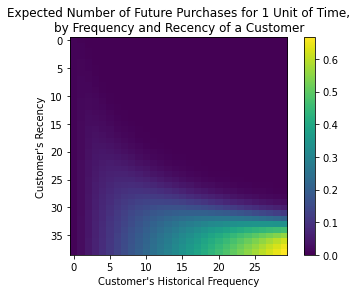

In [5]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

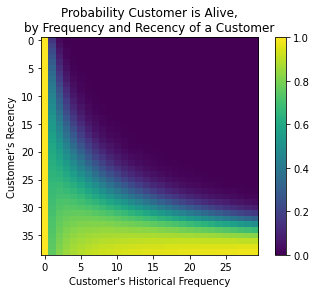

In [6]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [43]:
t = 7
#data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data['predicted_purchases'] = bgf.predict(t, data['frequency'], data['recency'], data['T'])

data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,2.564522
841,19,34.00,34.14,2.907998
1981,17,28.43,28.86,2.909434
157,29,37.71,38.00,4.100775
1516,26,30.86,31.00,4.344472


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

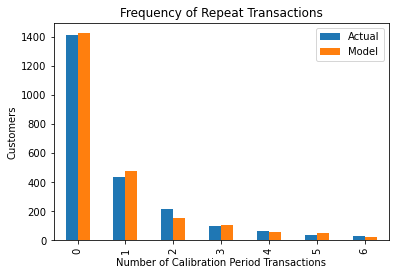

In [12]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## Example transactional data example

In [34]:
import pandas as pd

from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
transaction_data['date'] = pd.to_datetime(transaction_data['date'])
print(transaction_data.head())

        date  id
0 2014-03-08   0
1 2014-05-21   1
2 2014-03-14   2
3 2014-04-09   2
4 2014-05-21   2


In [35]:
# transforming transactional data (one row per purchase/visit) into summary data (a frequency, recency and age dataset).

summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [36]:
%time bgf.fit(summary['frequency'], summary['recency'], summary['T'])

CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 177 ms


<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

In [37]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0             121.0
1             0.0          0.0  103.0                0.0             121.0
2             6.0        142.0  171.0                0.0             121.0
3             0.0          0.0   26.0                0.0             121.0
4             2.0          9.0   62.0                0.0             121.0


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

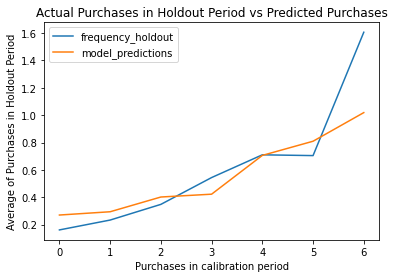

In [38]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [39]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.189680,0.005068,0.179748,0.199613
alpha,2.263306,0.117234,2.033528,2.493084
a,1.960002,0.172875,1.621168,2.298837
b,3.475725,0.391022,2.709322,4.242127


In [40]:
t = 10 #predict purchases in 10 periods
individual = summary.iloc[20]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
# 0.0576511

0.05765116591827107

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

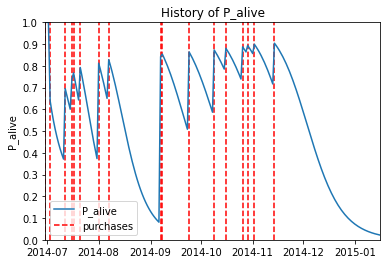

In [41]:
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
sp_trans['date'] = pd.to_datetime(sp_trans['date'])

plot_history_alive(bgf, days_since_birth, sp_trans, 'date')